In [1]:
# importing libraries
import os
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
from skimage import data, exposure
import numpy as np
import pywt
import pywt.data
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [2]:
path = 'C:/Users/Gebruiker/Desktop/Year 4/AMLS-assignment'

In [79]:
print(path)

C:/Users/Gebruiker/Desktop/Year 4/AMLS-assignment


# Feature Selection Algorithms and Functions

In [220]:
# first feature selection technique is HOG
def calculate_hog_features(image):
    hog_image = cv2.resize(image, (256, 128), interpolation=cv2.INTER_AREA)
    fd, hog_image = hog(hog_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    return fd, hog_image

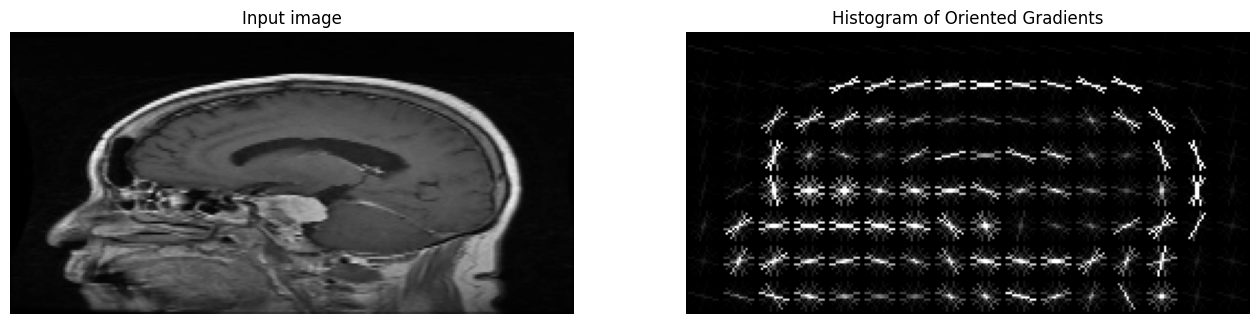

In [81]:
# showing example of what the hog features show

img = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fd, hog_image = calculate_hog_features(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

img = cv2.resize(img, (256, 128))

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [221]:
# second feature is wavelets with 'haar' feature

# adapting function so that I can apply the transform multiple times
def wavelet_feature(original, iterations):
    for i in range(iterations):
        coeffs = pywt.dwt2(original, 'haar')
        LL, (LH, HL, HH) = coeffs
        original = LL
    return coeffs

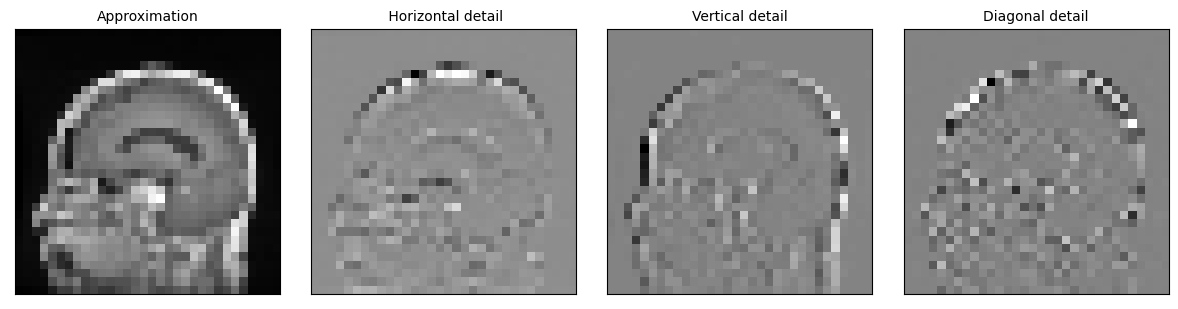

In [83]:
# Load image
original = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 4)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

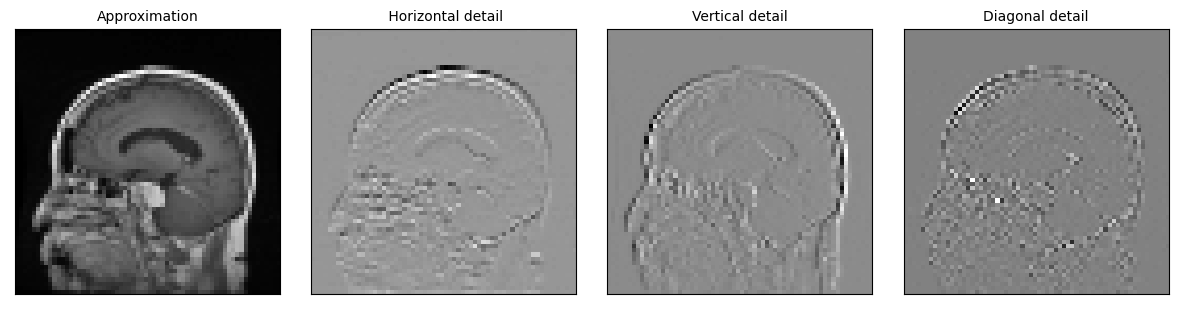

In [84]:
# Load image
original = cv2.imread(os.path.join(path, 'dataset/image/IMAGE_0000.jpg'))
original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Wavelet transform of image, and plot approximation and details
titles = ['Approximation', ' Horizontal detail',
          'Vertical detail', 'Diagonal detail']
coeffs = wavelet_feature(original, 3)
LL, (LH, HL, HH) = coeffs
fig = plt.figure(figsize=(12, 3))
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

# Data Augmentation

In [105]:
# saving features for comparisons
# creating directories for features to go in
import shutil

try:
    os.mkdir(os.path.join(path, 'Task A/features'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task A/features/train'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task A/features/train_aug'))
except:
    print('Directory already created')
try:
    os.mkdir(os.path.join(path, 'Task A/features/validate'))
except:
    print('Directory already created')


Directory already created
Directory already created
Directory already created
Directory already created


In [106]:
# splitting test and train data
df = pd.read_csv(path + '/dataset/label.csv')

# using random state so that it is repeatable
df_train = df.sample(frac=0.7,random_state=0)
df_validate = df.drop(df_train.index)

In [112]:
import shutil
# data augmentation on training set
import imgaug.augmenters as iaa

shutil.rmtree(path + '/dataset/image_aug')
os.makedirs(path + '/dataset/image_aug')

# creating sequences for images
seq_flip = iaa.Sequential([
    iaa.Fliplr(1)
])
seq_rotate = iaa.Sequential([
    iaa.Affine(rotate=(90, -90))
])
images = []
labels = []
# saving all images and labels to arrays for use later
for row in tqdm(df_train.iterrows()):
    image_name = row[1][0]
    label = row[1][1]
    if label == 'no_tumor':
        img = cv2.imread(os.path.join(path, f'dataset/image/{image_name}'))
        images.append(img)
        labels.append(label)

print(len(images))

# applying transforms to all images
rotated = seq_rotate(images=images)
flipped = seq_flip(images=images)

# creating new dataframe to store augmented images
df_aug = pd.DataFrame(columns=['file_name', 'label'])


for i in tqdm(range(len(images))):
    cv2.imwrite(path + '/dataset/image_aug/rotated_{:0>4}.jpg'.format(i), rotated[i])
    cv2.imwrite(path + '/dataset/image_aug/flipped_{:0>4}.jpg'.format(i), flipped[i])

    new1 = {'file_name': 'rotated_{:0>4}.jpg'.format(i), 'label': labels[i]}
    new2 = {'file_name': 'flipped_{:0>4}.jpg'.format(i), 'label': labels[i]}

    df_aug = df_aug.append(new1, ignore_index=True)
    df_aug = df_aug.append(new2, ignore_index=True)

2100it [00:00, 3222.88it/s]


319


100%|██████████| 319/319 [00:02<00:00, 120.22it/s]


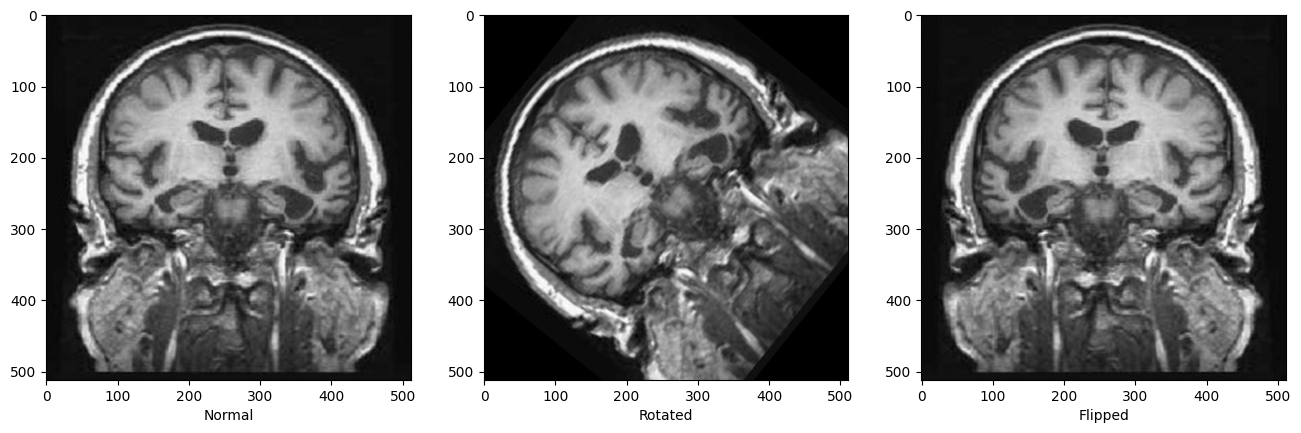

In [113]:
# visualising transformations

fig = plt.figure(figsize=(16, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(images[0])
plt.xlabel('Normal')
fig.add_subplot(1, 3, 2)
plt.imshow(rotated[0])
plt.xlabel('Rotated')
fig.add_subplot(1, 3, 3)
plt.imshow(flipped[0])
plt.xlabel('Flipped')
plt.show()
fig.savefig(path + '/augmentation.png')

In [114]:
df_aug

,file_name,label
0,rotated_0000.jpg,no_tumor
1,flipped_0000.jpg,no_tumor
2,rotated_0001.jpg,no_tumor
3,flipped_0001.jpg,no_tumor
4,rotated_0002.jpg,no_tumor
...,...,...
633,flipped_0316.jpg,no_tumor
634,rotated_0317.jpg,no_tumor
635,flipped_0317.jpg,no_tumor
636,rotated_0318.jpg,no_tumor


In [217]:
try:
    os.makedirs(path + '/Task A/features/test')
except:
    print('Directory exists')

df_test = pd.read_csv(path + '/dataset/test/label.csv')


Directory exists


# Extracting Features

In [218]:
# turning classes into numbers so that it can be used as a binary classifier
classes = {'meningioma_tumor': 0, 'no_tumor': 1, 'glioma_tumor': 1, 'pituitary_tumor': 1}


# creating function to preprocess images and then extract features and save them to the correct place for later use

def feature_extraction(data, aug, save_dir, test):
    hog_features = []
    wavelet_features_2 = []
    wavelet_features_3 = []
    labels = []
    if aug == True:
        image_dir = 'image_aug'
    elif test == True:
        image_dir = 'test/image'

    else:
        image_dir = 'image'

    for row in tqdm(data.iterrows()):
        image_name = row[1][0]
        label = row[1][1]
        # opening image
        img = cv2.imread(path + f'./dataset/{image_dir}/{image_name}')
        
        # grayscaling image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # normalising images between 0 and 1
        img = img/255

        # resizing images to 256 pixels square

        img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)


        # creating features and appending to arrays
        features, hog_image = calculate_hog_features(img)
        hog_features.append(features)

        features = wavelet_feature(img, 2)
        LL, (LH, HL, HH) = features
        wavelet_features_2.append(LL.flatten())

        features = wavelet_feature(img, 3)
        LL, (LH, HL, HH) = features
        wavelet_features_3.append(LL.flatten())

        # saving labels
        labels.append(classes[label])

    #saving features
    np.save(f'{save_dir}/hog.npy', hog_features)
    np.save(f'{save_dir}/wavelet_2x.npy', wavelet_features_2)
    np.save(f'{save_dir}/wavelet_3x.npy', wavelet_features_3)
    np.save(f'{save_dir}/labels.npy', labels)

In [116]:
# running feature extraction on all dataframes

feature_extraction(df_train, aug=False, save_dir=path + '/Task A/features/train', test=False)
feature_extraction(df_validate, aug=False, save_dir=path + '/Task A/features/validate', test=False)
feature_extraction(df_aug, aug=True, save_dir=path + '/Task A/features/train_aug', test=False)
feature_extraction(df_test, False, path + '/Task A/features/test', test=True)

2100it [00:34, 61.09it/s]
900it [00:14, 62.18it/s]
638it [00:12, 51.66it/s]


In [3]:
# creating function for classification so different parameters can be selected for evaluation of different models

def classifier(features_selected, augmented, classifier):
    # loading features

    x_train = []
    x_validate = []
    x_test = []
    for feature_type in features_selected:
        # loading features
        if augmented == False:
            x_train.append(np.load(path + f'/Task A/features/train/{feature_type}.npy'))
            x_test.append(np.load(path + f'/Task A/features/test/{feature_type}.npy'))
            x_validate.append(np.load(path + f'/Task A/features/validate/{feature_type}.npy'))

            y_train = np.load(path + f'/Task A/features/train/labels.npy')
            y_test = np.load(path + f'/Task A/features/test/labels.npy')
            y_validate = np.load(path + f'/Task A/features/validate/labels.npy')
        else:
            y_train = []
            temp = []
            temp.append(np.load(path + f'/Task A/features/train/{feature_type}.npy'))
            temp.append(np.load(path + f'/Task A/features/train_aug/{feature_type}.npy'))
            temp = tuple(temp)
            temp = np.concatenate(temp, axis=0)
            x_train.append(temp)

            x_test.append(np.load(path + f'/Task A/features/test/{feature_type}.npy'))
            x_validate.append(np.load(path + f'/Task A/features/validate/{feature_type}.npy'))

            y_train.append(np.load(path + f'/Task A/features/train/labels.npy'))
            y_train.append(np.load(path + f'/Task A/features/train_aug/labels.npy'))
            y_train = tuple(y_train)
            y_train = np.concatenate(y_train, axis=0)
            y_test = np.load(path + f'/Task A/features/test/labels.npy')
            y_validate = np.load(path + f'/Task A/features/validate/labels.npy')

    x_train = tuple(x_train)
    x_test = tuple(x_test)
    x_validate = tuple(x_validate)
    x_train = np.concatenate(x_train, axis=1)
    x_test = np.concatenate(x_test, axis=1)
    x_validate = np.concatenate(x_validate, axis=1)

    # creating pipelines for different classifiers

    # standard scalar and PCA is used for all classifiers
    scalar = StandardScaler()
    pca = PCA()

    if classifier == 'svm':
        # svm classifier uses sklearn svm and hyperparameters are selected using grid search
        clf = svm.SVC()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("svc", clf)])

        parameters = {
            'svc__kernel':['rbf'], 
            'svc__C':[0.1, 1, 10], 
            'svc__gamma':[0.01, 0.001, 0.0001], 
            'pca__n_components': [0.9, 0.95, 0.99, 50, 100]
        }

        

    elif classifier == 'random forest':
        # random forest classifier uses sklearn svm and hyperparameters are selected using grid search
        clf = RandomForestClassifier()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

        parameters = {
            'clf__n_estimators': [10, 50, 100, 200],
            'clf__bootstrap': [True],
            'pca__n_components': [50, 100, 150]
        }

    elif classifier == 'knn':
        clf = KNeighborsClassifier()
        pipe = Pipeline(steps=[("scalar", scalar), ("pca", pca), ("clf", clf)])

        parameters = {
            'clf__n_neighbors': [1, 2, 3],
            'pca__n_components': [0.9, 0.95, 0.99, 50, 100]
        }
    # grid search on the parameters
    grid = HalvingGridSearchCV(pipe, parameters, refit=True,  verbose = 3)
    grid.fit(x_train, y_train)

    return grid, x_test, y_test, x_validate, y_validate

# Training and Evaluating Classifiers and Features

In [ ]:
# creating function to test a variety of different combinations and select the best features
features = ['hog', 'wavelet_3x', 'wavelet_2x']
grid, x_val, y_val = classifier(features, augmented=True, classifier='knn')

In [21]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'clf__n_neighbors': 1, 'pca__n_components': 0.99}
Pipeline(steps=[('scalar', StandardScaler()), ('pca', PCA(n_components=0.99)),
                ('clf', KNeighborsClassifier(n_neighbors=1))])


C:\Users\Gebruiker\.conda\envs\AMLS-assigment\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


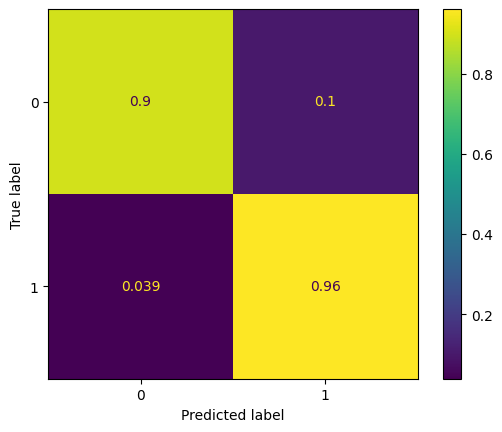

accuracy:  0.9422222222222222
f1 score:  0.9593114241001565
{'no_tumor': {'precision': 0.9038461538461539, 'recall': 0.8969465648854962, 'f1-score': 0.900383141762452, 'support': 262}, 'tumor': {'precision': 0.9578125, 'recall': 0.9608150470219435, 'f1-score': 0.9593114241001565, 'support': 638}, 'accuracy': 0.9422222222222222, 'macro avg': {'precision': 0.930829326923077, 'recall': 0.9288808059537199, 'f1-score': 0.9298472829313043, 'support': 900}, 'weighted avg': {'precision': 0.942102297008547, 'recall': 0.9422222222222222, 'f1-score': 0.942156746352958, 'support': 900}}


In [22]:
from sklearn.metrics import f1_score
plot_confusion_matrix(grid, x_val, y_val, normalize='true')
plt.show()

pred = grid.predict(x_val)
accuracy = accuracy_score(y_val, pred)
f1 = f1_score(y_val, pred)
print('accuracy: ', accuracy)
print('f1 score: ', f1)
# print classification report
report = classification_report(y_val, pred, output_dict=True, target_names=['no_tumor', 'tumor'])
print(report)

In [26]:
accuracy = report['accuracy']
f1_no_tumor = report['no_tumor']['f1-score']
f1_tumor = report['tumor']['f1-score']

print(accuracy, f1_no_tumor, f1_tumor)

0.9422222222222222 0.900383141762452 0.9593114241001565


In [101]:
print(grid.best_estimator_[2])

KNeighborsClassifier(n_neighbors=1)


In [4]:
df_results = pd.DataFrame(columns=['Classifier', 'Augmented', 'Features', 'PCA', 'Classifier_Metrics', 'Val accuracy', 'Test accuracy','f1 no_tumor', 'f1 tumor'])

In [5]:
df_results

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,f1 no_tumor,f1 tumor


In [ ]:
import itertools

augment = [False, True]
classification = ['svm', 'random forest', 'knn']
features = ['hog', 'wavelet_3x', 'wavelet_2x']

all_combinations = []
for r in range(len(features) + 1):
    combinations_object = itertools.combinations(features, r)
    combinations_list = list(combinations_object)
    all_combinations += combinations_list

del all_combinations[0]

print(all_combinations)
for aug in augment:
    for classif in classification:
        for feature in all_combinations:
            grid, x_test, y_test, x_val, y_val = classifier(feature, aug, classif)
            pred = grid.predict(x_val)
            params = str(grid.best_estimator_)
            val_report = classification_report(y_val, pred, output_dict=True, target_names=['no_tumor', 'tumor'])
            pred2 = grid.predict(x_test)
            test_report = classification_report(y_test, pred2, output_dict=True, target_names=['no_tumor', 'tumor'])
            new_row = {
                'Classifier': classif,
                'Augmented': str(aug),
                'Features': str(feature),
                'PCA': str(grid.best_estimator_[1]),
                'Classifier_Metrics': str(grid.best_estimator_[2]),
                'Val accuracy': val_report['accuracy'],
                'Test accuracy': test_report['accuracy'], 
                'f1 no_tumor': test_report['no_tumor']['f1-score'], 
                'f1 tumor': test_report['tumor']['f1-score']
                }
            df_results = df_results.append(new_row, ignore_index=True)
            df_results.to_csv(path + '/Task A/results5.csv', index=False)
            


In [ ]:
df_results = pd.read_csv(path + '/Task A/results5.csv')

In [35]:
df_results_top_5 = df_results.nlargest(5, ['Test accuracy']).sort_values('Test accuracy', ascending=False)
df_results_top_5

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,f1 no_tumor,f1 tumor
25,svm,True,"('hog', 'wavelet_2x')",PCA(n_components=100),"SVC(C=10, gamma=0.001)",0.942222,0.940,0.906250,0.955882
14,knn,False,"('hog',)",PCA(n_components=0.99),KNeighborsClassifier(n_neighbors=1),0.951111,0.935,0.900763,0.951673
27,svm,True,"('hog', 'wavelet_3x', 'wavelet_2x')",PCA(n_components=100),"SVC(C=10, gamma=0.001)",0.936667,0.935,0.897638,0.952381
35,knn,True,"('hog',)",PCA(n_components=0.9),KNeighborsClassifier(n_neighbors=1),0.960000,0.935,0.902256,0.951311
3,svm,False,"('hog', 'wavelet_3x')",PCA(n_components=100),"SVC(C=10, gamma=0.001)",0.954444,0.920,0.878788,0.940299


# Data exploration

<Figure size 3200x1600 with 0 Axes>

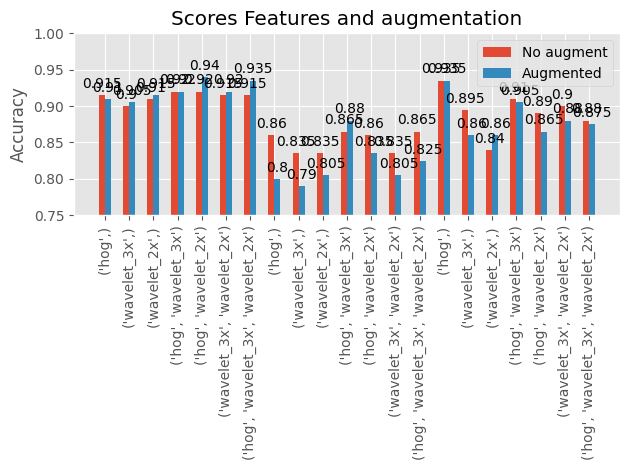

In [195]:
labels = df_results[df_results['Augmented'] == False]['Features'].tolist()
no_aug = df_results[df_results['Augmented'] == False]
aug = df_results[df_results['Augmented'] == True]

x = np.arange(len(labels))*4  # the label locations
width = 1  # the width of the bars
plt.style.use('ggplot')
plt.figure(figsize=(32, 16))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, no_aug['Test accuracy'].to_list(), width, label='No augment')
rects2 = ax.bar(x + width/2, aug['Test accuracy'].to_list(), width, label='Augmented')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('Scores Features and augmentation')
ax.set_xticks(x, labels, rotation=90)
ax.set_ylim(0.75, 1)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [177]:
df_results_new = df_results.assign(PCA = lambda x: x['PCA'].str.extract('(\d+.\d+|\d+)'))
df_results_new[['Val accuracy', 'Test accuracy', 'f1 no_tumor', 'f1 tumor']] = df_results_new[['Val accuracy', 'Test accuracy', 'f1 no_tumor', 'f1 tumor']].round(decimals = 4)
df_results_new = df_results_new.assign(Classifier_Metrics = lambda x: x['Classifier_Metrics'].str.extract(r'(\(.*)'))

In [4]:
df_results_new.to_csv(path + '/Task A/results_binary.csv', index=False)

NameError: name 'df_results_new' is not defined

In [56]:
df_results = pd.read_csv(path + '/Task A/results_binary.csv')

In [57]:
df_results_top_5 = df_results.nlargest(5, ['Test accuracy']).sort_values('Test accuracy', ascending=False)
df_results_top_5

,Classifier,Augmented,Features,PCA,Classifier_Metrics,Val accuracy,Test accuracy,f1 no_tumor,f1 tumor
25,svm,True,"('hog', 'wavelet_2x')",100.00,"(C=10, gamma=0.001)",0.9422,0.940,0.9062,0.9559
14,knn,False,"('hog',)",0.99,(n_neighbors=1),0.9511,0.935,0.9008,0.9517
27,svm,True,"('hog', 'wavelet_3x', 'wavelet_2x')",100.00,"(C=10, gamma=0.001)",0.9367,0.935,0.8976,0.9524
35,knn,True,"('hog',)",0.90,(n_neighbors=1),0.9600,0.935,0.9023,0.9513
3,svm,False,"('hog', 'wavelet_3x')",100.00,"(C=10, gamma=0.001)",0.9544,0.920,0.8788,0.9403


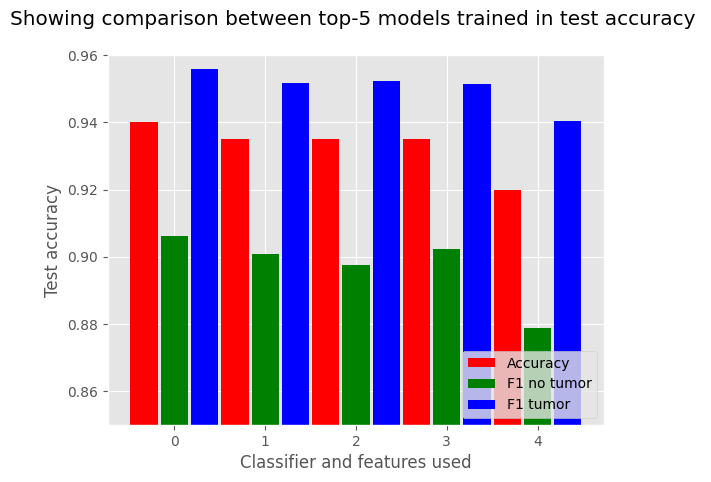

In [104]:
plt.style.use('ggplot')

# plt.figure(figsize=(16, 8))
labels = df_results_top_5['Classifier'] + df_results_top_5['Features']

x = np.array([0, 1, 2, 3, 4])

width = 0.3

plt.bar(x - 1/3, df_results_top_5['Test accuracy'],  color='red', width = width)
plt.bar(x, df_results_top_5['f1 no_tumor'],  color='green', width = width)
plt.bar(x + 1/3, df_results_top_5['f1 tumor'],  color='blue', width = width)

plt.ylim(.85, .96)
plt.ylabel('Test accuracy')
plt.xlabel('Classifier and features used')
plt.title('Showing comparison between top-5 models trained in test accuracy \n')
plt.legend(['Accuracy', 'F1 no tumor', 'F1 tumor'], loc=4)

plt.show()

In [107]:
augmented = df_results['Augmented']

augmented_results = df_results[augmented]['Test accuracy'].describe()
non_augmented_results = df_results[~augmented]['Test accuracy'].describe()

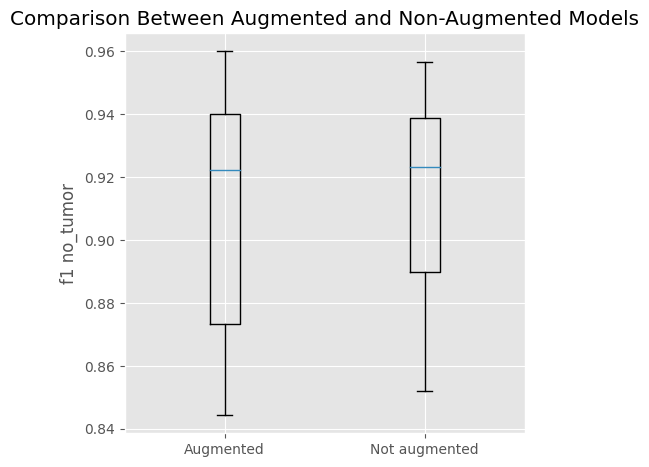

In [169]:
data1 = df_results[augmented]['Val accuracy']
data2 = df_results[~augmented]['Val accuracy']

# data3 = df_results[augmented]['Test accuracy']
# data4 = df_results[~augmented]['Test accuracy']

fig = plt.figure(figsize =(4, 4))

 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot([data1, data2])
ax.set_xticks([1, 2],['Augmented', 'Not augmented'])
# ax.set_xlabel('Data augmentation used')
ax.set_ylabel('f1 no_tumor')



# ax1 = fig.add_axes([1.5, 0, 1, 1])

# bp = ax1.boxplot([data3, data4])
# ax1.set_xticks([1, 2],['Augmented', 'Not augmented'])
# # ax.set_xlabel('Data augmentation used')
# ax1.set_ylabel('Test accuracy')

plt.title('Comparison Between Augmented and Non-Augmented Models')
 
# show plot
plt.show()

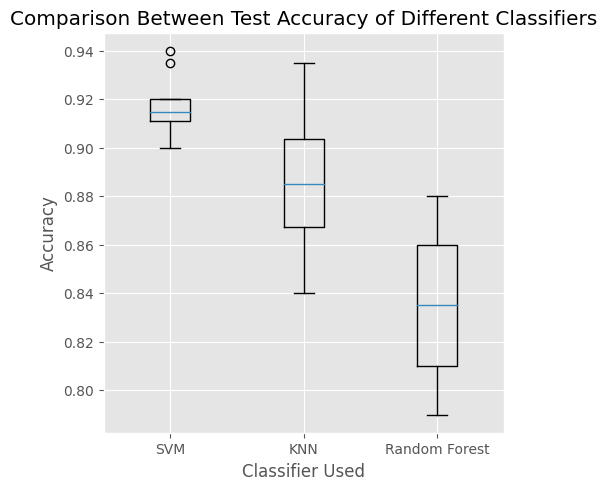

In [182]:
data1 = df_results[df_results['Classifier'] == 'svm']['Test accuracy']
data2 = df_results[df_results['Classifier'] == 'knn']['Test accuracy']
data3 = df_results[df_results['Classifier'] == 'random forest']['Test accuracy']

# data3 = df_results[augmented]['accuracy']
# data4 = df_results[~augmented]['accuracy']

fig = plt.figure(figsize =(4, 4))

 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot([data1, data2, data3])
ax.set_xticks([1, 2, 3],['SVM', 'KNN', 'Random Forest'])
# ax.set_xlabel('Data augmentation used')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Classifier Used')


# ax1 = fig.add_axes([1.5, 0, 1, 1])

# bp = ax1.boxplot([data3, data4])
# ax1.set_xticks([1, 2],['Augmented', 'Not augmented'])
# # ax.set_xlabel('Data augmentation used')
# ax1.set_ylabel('accuracy')

plt.title('Comparison Between Test Accuracy of Different Classifiers')
 
# show plot
plt.show()